In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np 
import sklearn as sk
import seaborn as sns
import statsmodels.api as sm 
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import itertools
import warnings
import scipy.signal as sp
import math
from statsmodels.tsa.stattools import acf, pacf
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta
import datetime

C:\Users\trevo\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def convert_datetime(dTot):
    
    dTot['Date_Hour'] = pd.to_datetime(dTot.Date) + pd.to_timedelta(dTot.Hour, unit='h')
    dTot = dTot.drop(['Date','Hour'],axis = 1)
    dTot = dTot.set_index('Date_Hour')
    
    return dTot

In [3]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [71]:
#importing zonal data from 2015-2017, only taking total consumption
demand2013 = pd.read_csv("ZonalDemands_2013.csv", usecols = [0,1,2])
demand2014 = pd.read_csv("ZonalDemands_2014.csv", usecols = [0,1,2])
demand2015 = pd.read_csv("ZonalDemands_2015.csv", usecols = [0,1,2])
demand2016 = pd.read_csv("ZonalDemands_2016.csv", usecols = [0,1,2])
demand2017 = pd.read_csv("ZonalDemands_2017.csv", usecols = [0,1,2])

#convert to pandas dateTime
demand2013 = convert_datetime(demand2013).resample('D').mean()
demand2014 = convert_datetime(demand2014).resample('D').mean()
demand2015 = convert_datetime(demand2015).resample('D').mean()
demand2016 = convert_datetime(demand2016).resample('D').mean() #first day of 2017 january?
demand2016 = demand2016.drop(demand2016.index[len(demand2016)-1])
demand2017 = convert_datetime(demand2017).resample('D').mean()


In [82]:
#weekly forecast
forecast_length = 2

In [133]:
#build models and validate
def test_model (train, test, i):

    #convert by log
    dTot_train_log = np.log(train[i]) # change

    #EWMA and differencesmooth by 2 weeks
    dTot_train_log_ewma =  dTot_train_log - pd.ewma(dTot_train_log, halflife=7)


    #Fit Model (2,2,0) (0,3,0,12)
    mod = sm.tsa.statespace.SARIMAX(dTot_train_log_ewma.resample('D'),
                                    order=(0, 1, 2),
                                    seasonal_order=(0, 1, 0, 12),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    results = mod.fit()

 


    #Find results
    forecast_log_diff = pd.Series(results.get_forecast(steps = forecast_length).predicted_mean, copy = True)
    forecast_log_diff.index  = test[i].resample('D').mean().index
    
    #Add back EWMA
    forecast_log = pd.Series(pd.ewma(dTot_train_log, halflife=7).iloc[len(dTot_train_log)-1].Total, index=forecast_log_diff.index)
    forecast_log = forecast_log.add(forecast_log_diff, fill_value = 0)
    
    #Remove log
    forecast = np.exp(forecast_log)

    #plt.plot(forecast)
    #print(forecast)
    #plt.plot(test[i])
    #print(test[i])
    #plt.legend(['Forecast','Test'])

    AIC = results.aic
    RMSE = math.sqrt((((forecast[1] - test[0].Total)**2).mean())) #change test

    #print('AIC:')
    #print(AIC)
    #print('RMSE:')
    #print(RMSE)

    #plt.plot(dTot_train_log_ewma)
    #Plot auto and partial correlation
    #fig = plt.figure(figsize=(12,8))
    #ax1 = fig.add_subplot()
    #fig = sm.graphics.tsa.plot_acf(dTot_train_log_ewma, lags=40, ax=ax1)
    #ax2 = fig.add_subplot()
    #fig = sm.graphics.tsa.plot_pacf(dTot_train_log_ewma, lags=40, ax=ax2)

    return RMSE


In [135]:
#Spilt into train/test
train = []
test = []
results = []

ctr = forecast_length+1
train.append(pd.concat([demand2015,demand2016]))
test.append(demand2017.iloc[0:forecast_length])
results.append(test_model(train,test,0))

#int(round(365/forecast_length))

for i in range(1, 7):
    
    train.append(train[i-1].append(test[i-1]))
    test.append(demand2017.iloc[ctr:ctr+forecast_length])
    ctr = ctr + forecast_length+1
    results.append(test_model(train,test,i))
   
    
print(results)
print(np.mean(results))

C:\Users\trevo\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(halflife=7,min_periods=0,adjust=True,ignore_na=False).mean()
  
C:\Users\trevo\Anaconda3\lib\site-packages\numpy\core\numeric.py:544: FutureWarning: 
.resample() is now a deferred operation
You called __array__(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  return array(a, dtype, copy=False, order=order, subok=True)
C:\Users\trevo\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\trevo\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm

[1566.8926618879207, 504.31126043733093, 466.9381658723397, 1230.196127169208, 410.9771784211342, 2635.2854157144416, 3036.342615939631]
1407.277632206001


In [ ]:
#find SARIMAX with optimal hyperparameters

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(dTot_train_log_ewma,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue


ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:-1824.0954844715936
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:-1790.179947552922
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:-1726.3471784421533
ARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:-1703.9427906136634
ARIMA(0, 0, 0)x(0, 2, 1, 12)12 - AIC:-1115.129819714417
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-1822.3404690031432
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-1822.5562158387256
ARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:-1792.6634300618641
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:-1387.3474290601107
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:-1733.5031954195051
ARIMA(0, 0, 0)x(1, 1, 2, 12)12 - AIC:-1701.9678310914665
ARIMA(0, 0, 0)x(1, 2, 0, 12)12 - AIC:-730.7049383648155
ARIMA(0, 0, 0)x(1, 2, 1, 12)12 - AIC:-1299.5806631792393
ARIMA(0, 0, 0)x(1, 2, 2, 12)12 - AIC:-1564.7120533351426
ARIMA(0, 0, 0)x(2, 0, 0, 12)12 - AIC:-1804.1589782237302
ARIMA(0, 0, 0)x(2, 0, 1, 12)12 - AIC:-1806.2677710694027
ARIMA(0, 0, 0)x(2, 0, 2, 12)12 - AIC:-1878.1226166706463
ARIMA(0, 0, 0)x(2, 1, 0, 12)12 - A

In [29]:
mod = sm.tsa.statespace.SARIMAX(dTot_train_log_ewma,
                                order=(2, 2, 0),
                                seasonal_order=(0, 3, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              Total   No. Observations:                  738
Model:             SARIMAX(2, 2, 0)x(0, 3, 0, 12)   Log Likelihood                  -0.134
Date:                            Tue, 20 Mar 2018   AIC                              6.268
Time:                                    16:36:17   BIC                             20.080
Sample:                                01-01-2015   HQIC                            11.594
                                     - 01-06-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4110      0.026    -15.832      0.000      -0.462      -0.360
ar.L2         -0.6734      0.029   

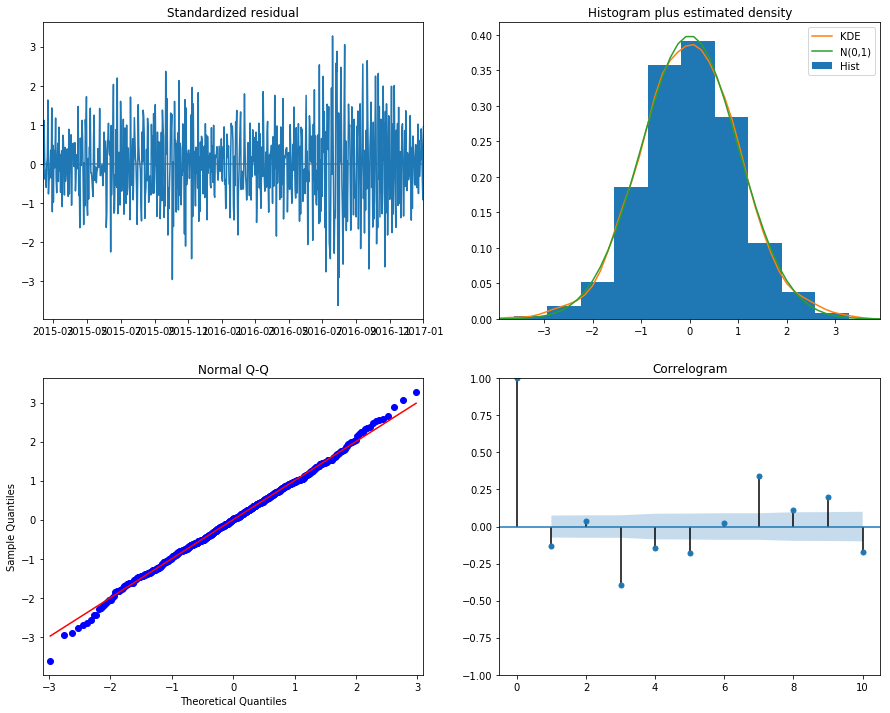

In [88]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()